# SLAM study

The purpose of this notebook is to start implementing the different SLAM algorithms. It will also be used to carry out tests, and to study and determine the best option.

## Introduction

After carrying out a study of the different SLAM algorithms and, in particular, those used for this type of vehicle, we found 3 important algorithms: EKF SLAM, Fast SLAM 2.0, Graph SLAM.

## Development

### Implementation planning

We will start by implementing simple filters for the location of the car. Then we will move on to Location and Maping starting with EKF SLAM because is a simpler algorithm and it will help us for the later implementation of the Particle Filter and it will help us gain a better understanding of these algorithms.

First, we will need to create a fake inputs: lidar scans, motion estimation...

We will implement this in small steps:

* 1.- Filtering : 

    * 1.1.- Modeling the uncertainty of the car using prob. distributions. Car's uncertainty grows as it moves. Measurments reduce de uncertainty. Combining a movement or prediction step with a measurement or correction step (Bayesian filter).
    * 1.2.- We will apply a specific prob. distr. (Gaussian) and derive the Kalman Filter (linear).
    * 1.3.- Since this is none linear --> Extended Kalman Filter
    * 1.4.- Particle Filter
    
    
* 2.- Simultaneous Location and Mapping

    * 2.1.- EKF SLAM: Location of the landmarks become part of the filter state. We will need a mechanism to modify the robot state to add landmarks because now we are creating a map. Measurement equation (relation between pose and landmark positions).
    * 2.2.- Particle SLAM: Factorization allows to split the posterior into a term for the car's pose which will be represented using particles and another term for the positions of all landmarks (individual Extended Kalman Filters where each particle holds a set of filters one for each landmark). 
    * 2.3.- Measurement update: either initialize new or update an existing landmark.
    * 2.4.- Remove spurious landmarks.

### 0.- Creating fake inputs

The SLAM module will receive inputs from modules Perception and Motion estimation.

### 0.1.- Perception

In perception, information from camera (Pablo) and Lidar (Alex U.) is processed. After detecting the cones, information will be combined and a single object list will be sent to the SLAM module. Each item in the list will consist of its x and y coordinates (relative to the car), the confidence interval, and a label on which the color of the cone is marked.


DE6.2.1 The markings of all dynamic events will have the following characteristics:
* The track is marked with cones.
* The left borders of the track are marked with small blue cones.
* The right borders of the track are marked with small yellow cones.
* Exit and entry lanes are marked with small orange cones.
* Big orange cones will be placed before and after start, finish and timekeeping lines.
* If not defined otherwise in chapter D of the rules, the maximum distance between two cones in driving direction is 5 m. In corners, the distance between the cones is smaller for a better indication.
* The start, finish and timekeeping lines as well as keep out zones around the timekeeping equipment are marked with red, orange or pink paint.
* Additionally for skid pad and trackdrive, track limit lines on either side of the track and entry/exit lanes may be marked with yellow, green or white paint.
* There are no track limit lines for acceleration and Emergency Brake System (EBS)-test.

As we are still not sure which sensors we will use for perception, we assume an angle of vision and a maximum distance of perception.

### Racing track

We invent a racing track to create the perception and motion estimation inputs from there.

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import csv
import pickle
from jupyterthemes import jtplot

jtplot.style()

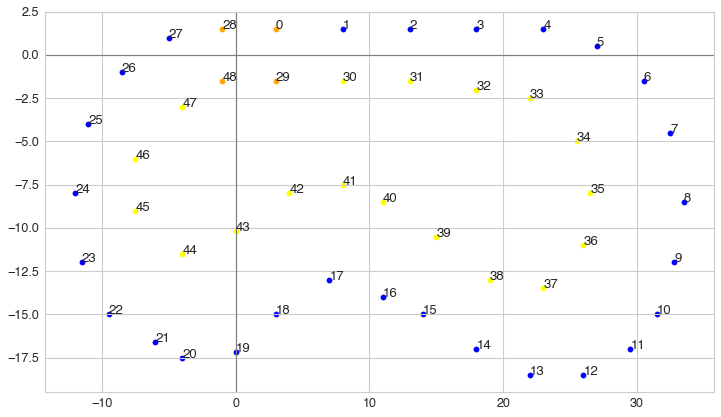

In [5]:
class Cone:
    def __init__(self, pose, ci, color):
        self.pose = pose
        self.ci = ci
        self.color = color
        self.values = [pose[1]/1000 , -pose[0]/1000, ci, color]

# hole circuit
#left
cone1 = Cone((-1500,3000),    1, 'orange')
cone2 = Cone((-1500,8000),    0.9+0.1*(np.random.uniform()), 'blue')
cone3 = Cone((-1500,13000),   0.8+0.2*(np.random.uniform()), 'blue')
cone4 = Cone((-1500,18000),   0.8+0.2*(np.random.uniform()), 'blue')
cone5 = Cone((-1500,23000),   0.8+0.2*(np.random.uniform()), 'blue')
cone6 = Cone((-500,27000),    0.7+0.3*(np.random.uniform()), 'blue')
cone7 = Cone((1500,30500),    0.7+0.3*(np.random.uniform()), 'blue')
cone8 = Cone((4500,32500),    0.7+0.3*(np.random.uniform()), 'blue')
cone9 = Cone((8500,33500),    0.7+0.3*(np.random.uniform()), 'blue')
cone10 = Cone((12000,32800),  0.7+0.3*(np.random.uniform()), 'blue')
cone11 = Cone((15000,31500),  0.7+0.3*(np.random.uniform()), 'blue')
cone12 = Cone((17000,29500),  0.7+0.3*(np.random.uniform()), 'blue')
cone13 = Cone((18500,26000),  0.7+0.3*(np.random.uniform()), 'blue')
cone14 = Cone((18500,22000),  0.7+0.3*(np.random.uniform()), 'blue')
cone15 = Cone((17000,18000),  0.7+0.3*(np.random.uniform()), 'blue')
cone16 = Cone((15000,14000),  0.7+0.3*(np.random.uniform()), 'blue')
cone17 = Cone((14000,11000),  0.7+0.3*(np.random.uniform()), 'blue')
cone18 = Cone((13000,7000),   0.7+0.3*(np.random.uniform()), 'blue')
cone19 = Cone((15000,3000),   0.7+0.3*(np.random.uniform()), 'blue')
cone20 = Cone((17200,0),      0.7+0.3*(np.random.uniform()), 'blue')
cone21 = Cone((17500,-4000),  0.7+0.3*(np.random.uniform()), 'blue')
cone22 = Cone((16600,-6000),  0.7+0.3*(np.random.uniform()), 'blue')
cone23 = Cone((15000,-9500),  0.7+0.3*(np.random.uniform()), 'blue')
cone24 = Cone((12000,-11500), 0.7+0.3*(np.random.uniform()), 'blue')
cone25 = Cone((8000,-12000),  0.7+0.3*(np.random.uniform()), 'blue')
cone26 = Cone((4000,-11000),  0.7+0.3*(np.random.uniform()), 'blue')
cone27 = Cone((1000,-8500),   0.7+0.3*(np.random.uniform()), 'blue')
cone28 = Cone((-1000,-5000),  0.7+0.3*(np.random.uniform()), 'blue')
cone29 = Cone((-1500,-1000),  0.7+0.3*(np.random.uniform()), 'orange')


#right
cone30 = Cone((1500,3000),    1,'orange')
cone31 = Cone((1500,8000),    0.9+0.1*(np.random.uniform()),'yellow')
cone32 = Cone((1500,13000),   0.8+0.2*(np.random.uniform()), 'yellow')
cone33 = Cone((2000,18000),   0.8+0.2*(np.random.uniform()), 'yellow')
cone34 = Cone((2500,22000),   0.8+0.2*(np.random.uniform()), 'yellow')
cone35 = Cone((5000,25500),   0.7+0.3*(np.random.uniform()), 'yellow')
cone36 = Cone((8000,26500),   0.7+0.3*(np.random.uniform()), 'yellow')
cone37 = Cone((11000,26000),  0.7+0.3*(np.random.uniform()), 'yellow')
cone38 = Cone((13500,23000),  0.7+0.3*(np.random.uniform()), 'yellow')
cone39 = Cone((13000,19000),  0.7+0.3*(np.random.uniform()), 'yellow')
cone40 = Cone((10500,15000),  0.7+0.3*(np.random.uniform()), 'yellow')
cone41 = Cone((8500,11000),   0.7+0.3*(np.random.uniform()), 'yellow')
cone42 = Cone((7500,8000),    0.7+0.3*(np.random.uniform()), 'yellow')
cone43 = Cone((8000,4000),    0.7+0.3*(np.random.uniform()), 'yellow')
cone44 = Cone((10200,0),      0.7+0.3*(np.random.uniform()), 'yellow')
cone45 = Cone((11500,-4000),  0.7+0.3*(np.random.uniform()), 'yellow')
cone46 = Cone((9000,-7500),   0.7+0.3*(np.random.uniform()), 'yellow')
cone47 = Cone((6000,-7500),   0.7+0.3*(np.random.uniform()), 'yellow')
cone48 = Cone((3000,-4000),   0.7+0.3*(np.random.uniform()), 'yellow')
cone49 = Cone((1500,-1000),   0.7+0.3*(np.random.uniform()), 'orange')


track_cones = [ cone1, cone2, cone3, cone4, cone5, cone6, cone7, cone8, cone9, cone10, cone11, cone12, cone13, cone14, cone15, cone16, cone17, cone18, cone19, cone20, cone21, cone22, cone23, cone24, cone25, cone26, cone27, cone28, cone29, cone30, cone31, cone32, cone33, cone34, cone35, cone36, cone37, cone38, cone39, cone40, cone41, cone42, cone43, cone44, cone45, cone46, cone47, cone48, cone49 ]

with open('../racetracks/track.csv', mode='w') as track:
    for cone in track_cones:
        employee_writer = csv.writer(track, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        employee_writer.writerow([round(cone.values[0], 4), round(cone.values[1],4), cone.color])

# plot        
plt.figure(figsize=(12, 7))

for i, cone in enumerate(track_cones):
    plt.scatter(cone.values[0], cone.values[1], color=cone.color)
    plt.annotate(f"{i}", (cone.values[0], cone.values[1])) #->{round(cone.values[0],1), round(cone.values[1],1)}", (cone.values[0], cone.values[1]))
    # plt.annotate(f"{i}", (cone.pose[0], cone.pose[1]))
    
plt.axhline(y=0, color='grey')
plt.axvline(x=0, color='grey')

plt.show()

Now, we have to make up the positions of the car (motion estimation).

Suposing new inputs arrive at 4Hz, max speed for SLAM mode is 10km/h (small circuit).

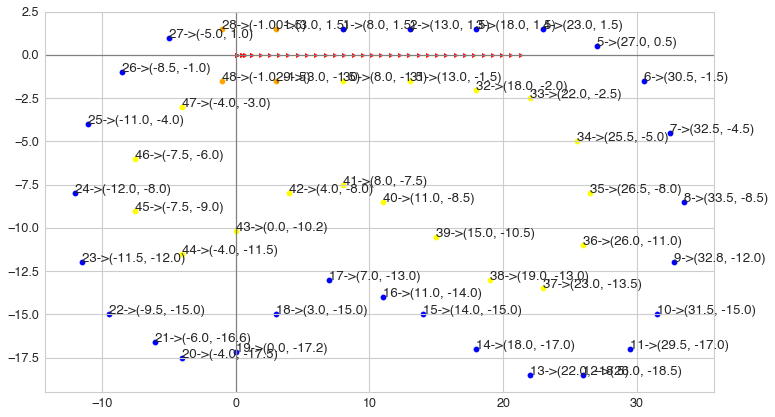

In [10]:
pos1  = (0,0,0)
pos2  = (0,0,0)
pos3  = (0,0,0)
pos4  = (0,0,0)

pos5  = (0,0,0)
pos6  = (0,0,0)
pos7  = (0,0,0)
pos8  = (0,0,0)

pos9  = (10,0,0) # 10
pos10 = (50,0,0) # 40
pos11 = (100,0,0) # 50
pos12 = (200,0,0) # 100

pos10 = (370,0,0) # 170
pos11 = (650,0,0) # 280
pos12 = (1130,0,0) # 480
pos13 = (1790,0,0) # 660

pos14 = (2484.5,0,0) # 669.5
pos15 = (3179.0,0,0) # 669.5
pos16 = (3873.5,0,0) # 669.5
pos17 = (4568.0,0,0) # 669.5

pos18 = (5262.5,0,0) # 669.5
pos19 = (5957.0,0,0) # ...
pos20 = (6651.5,0,0)
pos21 = (7346.0,0,0)

pos22 = (8040.5,0,0)
pos23 = (8735.0,0,0)
pos24 = (9429.5,0,0)
pos25 = (10124.0,0,0)

pos26 = (10818.5,0,0)
pos27 = (11513.0,0,0)
pos28 = (12207.5,0,0)
pos29 = (12902.0,0,0)

pos30 = (13596.5,0,0)
pos31 = (14291.0,0,0)
pos32 = (14985.5,0,0)
pos33 = (15680.0,0,0)

pos34 = (16374.5,0,0)
pos35 = (17069.0,0,0)
pos36 = (17763.5,0,0)
pos37 = (18458.0,0,0)

pos38 = (19152.5,0,0)
pos39 = (19847.0,0,0)
pos40 = (20541.5,0,0)
pos41 = (21236.0,0,0)

pos38 = (19152.5,0,0)
pos39 = (19847.0,0,0)
pos40 = (20541.5,0,0)
pos41 = (21236.0,0,0)

positions_initial = [pos1,pos2,pos3,pos4,pos5,pos6,pos7,pos8,pos9,pos10,pos11,pos12,pos10,pos11,pos12,pos13,pos14,pos15,pos16,pos17,pos18,pos19,pos20,pos21,pos22,pos23,pos24,pos25,pos26,pos27,pos28,pos29,pos30,pos31,pos32,pos33,pos34,pos35,pos36,pos37,pos38,pos39,pos40,pos41]
positions = [[x / 1000 for x in pos] for pos in positions_initial]


def draw_perception(pos, track_cones, srange=10):
    sens_range = srange
    car_perc = []
    for cone in track_cones:
        #print(pos[2] >= 0  , pos[0] <= (math.pi/2) , float(cone.values[0])>pos[0]  , float(cone.values[0])<pos[0]+sens_range  , float(abs(cone.values[1]))<pos[1]+sens_range)
        if(  (pos[2] >= 0) 
           & (pos[2] <= (math.pi/2))
           & (cone.values[0]>pos[0])
           & (cone.values[0]<pos[0]+sens_range*4)
           & (abs(cone.values[1])<pos[1]+sens_range)):
            car_perc.append([cone.values[0]-pos[0], cone.values[1]-pos[1], cone.values[2], cone.values[3]])
    return car_perc

# plot        
plt.figure(figsize=(12, 7))

for i, cone in enumerate(track_cones):
    plt.scatter(cone.values[0], cone.values[1], color=cone.color)
    plt.annotate(f"{i}->{round(cone.values[0],1), round(cone.values[1],1)}", (cone.values[0], cone.values[1]))
    # plt.annotate(f"{i}", (cone.pose[0], cone.pose[1]))
    
plt.axhline(y=0, color='grey')
plt.axvline(x=0, color='grey')


frames = {}
for i, pos in enumerate(positions):
    frames[f"frame{i}"] = draw_perception(pos, track_cones)
    plt.scatter(pos[0], pos[1], marker=(3, 0, -90), color="red")
    

coords = [[0.0, 0.0, 0.0, 1.5], [0.15000000000000002, -3.1913635232571056e-17, -2.1275756821714033e-16, 1.5], [0.30000000000000004,-6.382727046514211e-17, -2.1275756821714033e-16, 1.5], [0.45000000000000007, -9.574090569771317e-17, -2.1275756821714033e-16, 1.5], [0.6000000000000001, -1.2765454093028422e-16, -2.1275756821714033e-16, 1.5], [0.7500000000000001, -1.5956817616285528e-16, -2.1275756821714033e-16, 1.5], [0.9000000000000001, -1.9148181139542634e-16, -2.1275756821714033e-16, 1.5], [1.0500000000000003, -2.1771202726795715e-16, 6.823809809891212e-16, 1.5], [1.2000000000000002, -1.1535488011958897e-16, 6.823809809891212e-16, 1.5], [1.35, -1.2997732971220779e-17, 6.823809809891212e-16, 1.5], [1.5000000000000002, 8.93594141771465e-17, 6.823809809891142e-16, 1.5], [1.6500000000000004, 1.9171656132551363e-16, 6.823809809891142e-16, 1.5], [1.8000000000000003, 1.500155013761805e-16, -6.823809809891267e-16, 1.5], [1.9500000000000002, 4.765835422781148e-17, -6.823809809891267e-16, 1.5], [2.1000000000000005, -5.4698792920557404e-17, -6.823809809891249e-16, 1.5], [2.2500000000000004, -1.5705594006892615e-16, -6.823809809891249e-16, 1.5], [2.4000000000000004, -1.8467612263276833e-16, 6.823809809891137e-16, 1.5], [2.5500000000000003, -8.231897548440126e-17, 6.823809809891137e-16, 1.5], [2.7, -0.0, 0.0, 1.5], [2.8500000000000005, -0.0, 0.0, 1.5],[3.0000000000000004, -0.0, 0.0, 1.5], [3.1500000000000004, -0.0, 0.0, 1.5], [3.3000000000000007, 8.88178419700131e-17, 6.661338147750927e-16, 1.5], [3.4500000000000006, 1.8873791418627703e-16, 6.661338147750927e-16, 1.5], [3.6000000000000005, 1.5543122344752159e-16, -6.661338147750936e-16, 1.5], [3.7500000000000004, 5.551115123125753e-17, -6.661338147750936e-16, 1.5], [3.9000000000000004, -0.0, 0.0, 1.5], [4.050000000000001, -0.0, 0.0, 1.5], [4.200000000000001, -0.0, 0.0, 1.5], [4.3500000000000005, -0.0, 0.0, 1.5], [4.500000000000001, -0.0, 0.0, 1.5], [4.65, -0.0, 0.0, 1.5], [4.800000000000001, -0.0, 0.0, 1.5], [4.950000000000001, -0.0, 0.0, 1.5], [5.1000000000000005, -0.0, 0.0, 1.5], [5.250000000000001, -0.0, 0.0, 1.5], [5.4, -0.0, 0.0, 1.5], [5.550000000000001, -0.0, 0.0, 1.5], [5.700000000000001, -0.0, 0.0, 1.5], [5.8500000000000005, -0.0, 0.0, 1.5], [6.000000000000001, -0.0, 0.0, 1.5], [6.150000000000001, -0.0, 0.0, 1.5], [6.300000000000001, -0.0, 0.0, 1.5], [6.450000000000001, -0.0, 0.0, 1.5], [6.6000000000000005, -0.0, 0.0, 1.5], [6.750000000000001, -0.0, 0.0, 1.5], [6.900000000000001, -0.0, 0.0, 1.5], [7.050000000000001, -0.0, 0.0, 1.5], [7.200000000000001, -0.0, 0.0, 1.5], [7.350000000000001, -0.0, 0.0, 1.5], [7.500000000000001, -0.0, 0.0, 1.5], [7.650000000000001, -0.0, 0.0, 1.5], [7.800000000000001, -0.0, 0.0, 1.5], [7.950000000000001, -0.0, 0.0, 1.5], [8.100000000000001, -0.0, 0.0, 1.5], [8.250000000000002, -0.0, 0.0, 1.5], [8.400000000000002, -0.0, 0.0, 1.5], [8.55, -0.0, 0.0, 1.5], [8.700000000000001, -0.0, 0.0, 1.5], [8.850000000000001, -0.0, 0.0, 1.5], [9.000000000000002, -0.0, 0.0, 1.5], [9.150000000000002, -0.0, 0.0, 1.5], [9.3, -0.0, 0.0, 1.5], [9.450000000000001, -0.0, 0.0,1.5], [9.600000000000001, -0.0, 0.0, 1.5], [9.750000000000002, -0.0, 0.0, 1.5], [9.900000000000002, -0.0, 0.0, 1.5], [10.05, -0.0, 0.0, 1.5], [10.200000000000001, -0.0, 0.0, 1.5], [10.350000000000001, -0.0, 0.0, 1.5], [10.500000000000002, -0.0, 0.0, 1.5], [10.650000000000002, -0.0, 0.0, 1.5], [10.8, -0.0, 0.0, 1.5], [10.950000000000001, -0.0, 0.0, 1.5], [11.100000000000001, -0.0, 0.0, 1.5], [11.250000000000002, -0.0, 0.0, 1.5], [11.400000000000002, -0.0, 0.0, 1.5], [11.550000000000002, -0.0, 0.0, 1.5], [11.700000000000001, -0.0, 0.0, 1.5], [11.850000000000001, 1.1102230246253449e-17, 6.661338147750892e-16, 1.5]]
coords1 = [[0.0, 0.0, 0.0, 1.5], [0.1497831276082361, -0.0080631683533737, -0.05378037703049132, 1.5], [0.2995662552164723, -0.016126336706747395, -0.05378037703049132, 1.5], [0.4493493828247084, -0.024189505060121096, -0.05378037703049132, 1.5], [0.5991325104329446, -0.032252673413494796, -0.05378037703049132, 1.5], [0.7489156380411808, -0.0403158417668685, -0.05378037703049132, 1.5], [0.898698765649417, -0.0483790101202422, -0.05378037703049132, 1.5], [1.0485160409851852, -0.055177066041093126,-0.00019022255809891114, 1.5], [1.1985160382713387, -0.05520559942463588, -0.00019022255809891114, 1.5], [1.3482583606867846, -0.06143559778299929, -0.08286329368461247, 1.5], [1.498232093813906, -0.062099597119090855, -0.0002139851128815295, 1.5], [1.6480819602901486, -0.06574307042909551, -0.08288105339609493, 1.5], [1.7979483332007578, -0.06899210653428257, -0.00023774427777006427, 1.5], [1.9479058349383893, -0.07004944979399166, -0.08289881051753294, 1.5], [2.097664756598603, -0.0758831280017897, -0.000261500053473058, 1.5], [2.247664751469932, -0.0759223530093636, -0.000261500053473058, 1.5], [2.397381364174063, -0.08277266185311367, -0.0002852524406801173, 1.5], [2.5473813580713918, -0.08281544971863543, -0.0002852524406801173, 1.5], [2.6970981560936753, -0.08966070841967468, -0.00030900144009774546, 1.5], [2.8470981489325338, -0.08970705863495174, -0.00030900144009774546, 1.5], [2.9968633278346775, -0.09539057577970732, -0.08295206634720806, 1.5], [3.1468151242198448, -0.09659718008975945, -0.0003327470524126147, 1.5], [3.2966880832906758, -0.09969523751958258, -0.0829698131140526, 1.5], [3.4465322840997246, -0.10348581441442278, -0.00035648927833536076, 1.5], [3.596513114385444, -0.10399880690733086, -0.0829875572936487, 1.5], [3.7462496287384877, -0.11037296194023416, -0.0003802281185551648, 1.5], [3.8962496178954815, -0.11042999615664316, -0.0003802281185551648, 1.5], [4.045967158302363, -0.11725862299839955, -0.00040396357378052946, 1.5], [4.195967146063371, -0.1173192175328186, -0.00040396357378052946, 1.5], [4.345684872957492, -0.12414279792005177, -0.000427695644692341, 1.5], [4.495684859238225, -0.12420695226479973, -0.000427695644692341, 1.5], [4.645472977082343, -0.12934476892555094, -0.08304077431437043, 1.5], [4.795402757586138, -0.13109320068374153, -0.0004514243319962124, 1.5], [4.945298891282805, -0.13364662244943387, -0.08305850815046929, 1.5], [5.095120841273116, -0.13797796312072122, -0.0004751496363870034, 1.5], [5.245120824340578, -0.13804923556349744, -0.0004751496363870034, 1.5], [5.39483911046508, -0.14486123990673555, -0.0004988715585683005, 1.5], [5.544839091799617, -0.14493607063741692, -0.0004988715585683005, 1.5], [5.694557565327864, -0.15174303137270279, -0.0005225900992266508, 1.5], [5.844557544845334, -0.1518214198840188, -0.0005225900992266508, 1.5], [5.9942762060272194, -0.1586233378494645, -0.0005463052590644982, 1.5], [6.1442761836435125, -0.15870528363424807, -0.0005463052590644982, 1.5], [6.294087322502123, -0.1632981809043549, -0.08312941765543731, 1.5], [6.4439950083598525, -0.1655876622189673, -0.0005700170387797199, 1.5], [6.59391439833151, -0.16759722890008355, -0.08314713857460174, 1.5], [6.7437140191599685,-0.172468555968963, -0.0005937254390557811, 1.5], [6.893713992721727, -0.172557614779589, -0.0005937254390557811, 1.5], [7.043433216209389, -0.1793479652149412, -0.0006174304606054332, 1.5], [7.193433187617862, -0.1794405797781476, -0.0006174304606054332, 1.5], [7.343152599673556, -0.18622589028753123, -0.000641132104112762, 1.5], [7.4931525688447795, -0.1863220600965597, -0.000641132104112762, 1.5], [7.642878415086369, -0.19295348041204352, -0.08320028584400806, 1.5], [7.792872136567873, -0.19320205606547736, -0.0006648303702769437, 1.5], [7.942706378131263, -0.19725081539845352, -0.08321799643961036, 1.5], [8.09259189095245, -0.2000805680154753, -0.000688525259795175, 1.5], [8.242534618466681, -0.20154706055147387, -0.08323570445569416, 1.5], [8.392311832163733, -0.2069575962770463, -0.0007122167733582739, 1.5], [8.54231179411978, -0.2070644287840182, -0.0007122167733582739, 1.5], [8.692031960366858, -0.2138331411806085, -0.0007359049116667909, 1.5], [8.842031919750156, -0.21394352690739518, -0.0007359049116667909, 1.5], [8.991752275726876, -0.22070720305649885, -0.0007595896754095087, 1.5], [9.141752232453642, -0.22082114149685364, -0.0007595896754095087, 1.5], [9.291501028139349, -0.22690814218766953, -0.08328881303240619, 1.5], [9.44147273239524, -0.22769727288275607, -0.0007832710652814696, 1.5], [9.591330157971987, -0.23120267608867853, -0.08330651073596058, 1.5], [9.741193419739865, -0.2345719213953866, -0.0008069490819808698, 1.5], [9.89115956568321, -0.23549612108204881, -0.08332420586277739, 1.5], [10.040914294652348, -0.24144508736494893, -0.0008306237261944635, 1.5], [10.190914242907168, -0.24156968090955117, -0.0008306237261944635, 1.5], [10.340635357297435, -0.2483167711215698,-0.0008542949986274353, 1.5], [10.490635302560943, -0.24844491535577687, -0.0008542949986274353, 1.5], [10.640356607839788, -0.2551869729952965, -0.0008779628999634966, 1.5], [10.790356550028378, -0.2553186674133723, -0.0008779628999634966, 1.5], [10.940128376507216, -0.26086203115717527, -0.08337727578823009, 1.5], [11.090077985474084, -0.26219093741241084, -0.0009016274309040823, 1.5], [11.239958675991584, -0.26515376665434615, -0.08339496061354197, 1.5], [11.389799609062585, -0.26906172568288367, -0.0009252885921380428, 1.5]]
coords2 = [[0.0, 0.0, 0.0, 1.5], [0.1497831276082361, -0.0080631683533737, -0.05378037703049132, 1.5], [0.2995662552164723, -0.016126336706747395, -0.05378037703049132, 1.5], [0.4493493828247084, -0.024189505060121096, -0.05378037703049132, 1.5], [0.5991325104329446, -0.032252673413494796, -0.05378037703049132, 1.5], [0.7489156380411808, -0.0403158417668685, -0.05378037703049132, 1.5], [0.898698765649417, -0.0483790101202422, -0.05378037703049132, 1.5], [1.0485160409851852, -0.055177066041093126,-0.00019022255809891114, 1.5], [1.1985160382713387, -0.05520559942463588, -0.00019022255809891114, 1.5]]
# coords3 = [[0.0, 0.0, 0.0, 1.5], [0.10889264170375568, -0.10316197256148962, -0.7583802430729046, 1.5], [0.21778528340751113, -0.20632394512297914, -0.7583802430729046, 1.5], [0.3266779251112666, -0.30948591768446854, -0.7583802430729046, 1.5], [0.43557056681502204, -0.41264789024595805, -0.7583802430729046, 1.5], [0.5444632085187776, -0.5158098628074477, -0.7583802430729046,1.5], [0.6533558502225332, -0.6189718353689372, -0.7583802430729046, 1.5], [0.7622484919262887, -0.7221338079304267, -0.7583802430729046, 1.5], [0.8711411336300443, -0.8252957804919163, -0.7583802430729046, 1.5], [0.9800337753337999, -0.9284577530534057, -0.7583802430729046, 1.5], [1.0889264170375554, -1.0316197256148953, -0.7583802430729046, 1.5], [1.197819058741311, -1.134781698176385, -0.7583802430729046, 1.5], [1.3222897957619018, -1.2131362952600917, -0.42685178232425575, 1.5], [1.4588308422171288, -1.2752373631487484, -0.42685178232425575, 1.5], [1.5968219515959883, -1.3337482361522655, -0.3408680122811439, 1.5], [1.733604486380428, -1.3952493279110438, -0.4269788599952625, 1.5], [1.8706096215296366, -1.4562002331741821, -0.34137155433080146, 1.5], [2.0083810213017528, -1.5152540718836571, -0.4271048200595977, 1.5], [2.1449063494723353, -1.577389687821015, -0.4271048200595977, 1.5], [2.2831604279698188, -1.6352516983895944, -0.427229677192231, 1.5], [2.419677997001413, -1.6974043600035897, -0.427229677192231, 1.5], [2.557942687524805, -1.7552423088821463, -0.4273534458124133, 1.5]]

def rotate(origin, point, angle):
    
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

#x = []
#y = []
#
#for coord in coords:
#    x.append(coord[0])
#    y.append(coord[1])
#    plt.scatter(coord[0], coord[1], marker='^', color="green")
    

#for coord in coords1:
#    rox, roy = rotate([11.85,0.0], [coord[0]+11.85,coord[1]],  -0.0537)
#    plt.scatter(rox*1000, roy*1000, marker='^', color="green")
#
#for coord in coords2:
#    rox, roy = rotate([11.85+11.389,-0.75], [coord[0]+11.85+11.389,coord[1]-0.85], -0.308)
#    plt.scatter(rox*1000, roy*1000, marker='^', color="green")

#for coord in coords3:
#    x.append((coord[0]+11.85))
#    y.append(coord[1])
#    plt.scatter((coord[0]+11.85+11.84)*1000, (coord[1]-0.276)*1000, marker='^', color="green")
    
plt.show()

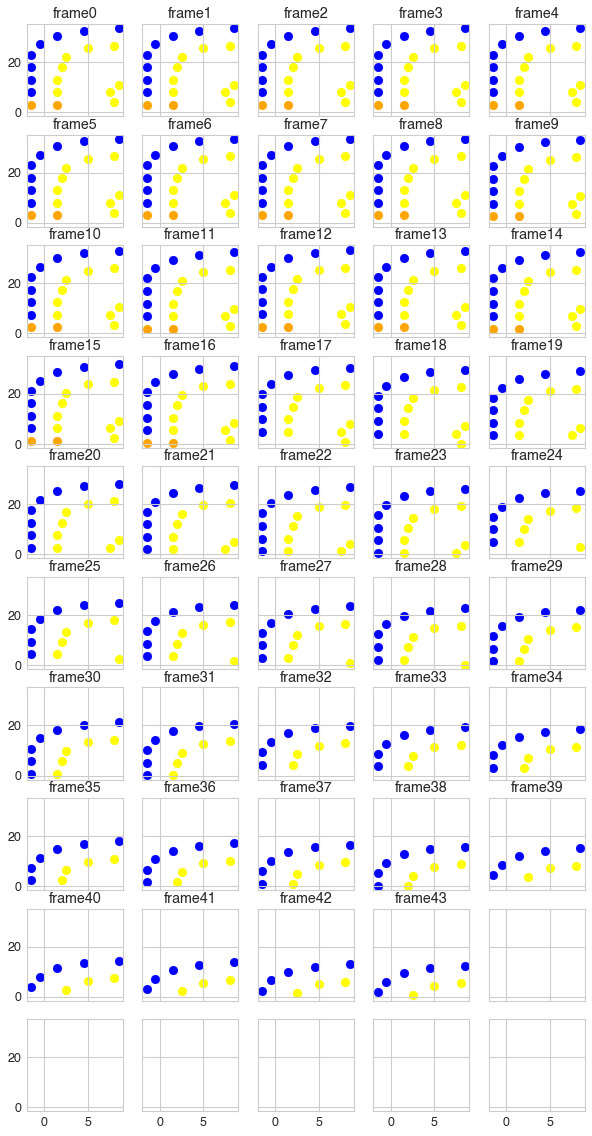

In [15]:
fig, axs = plt.subplots(10, 5, sharex=True, sharey=True,figsize=(10,20))

for i, frame in enumerate(frames):
    for cone in frames[frame]:
        axs[math.floor(i/5), i%5].scatter(-cone[1], cone[0], s=80, color=cone[3])
        axs[math.floor(i/5), i%5].set_title(f"{frame}")

plt.show()

In [16]:
!pwd

/Users/andresmontero/Desktop/EPFL/formula/EPFL-RT-Driverless/slam/inputs


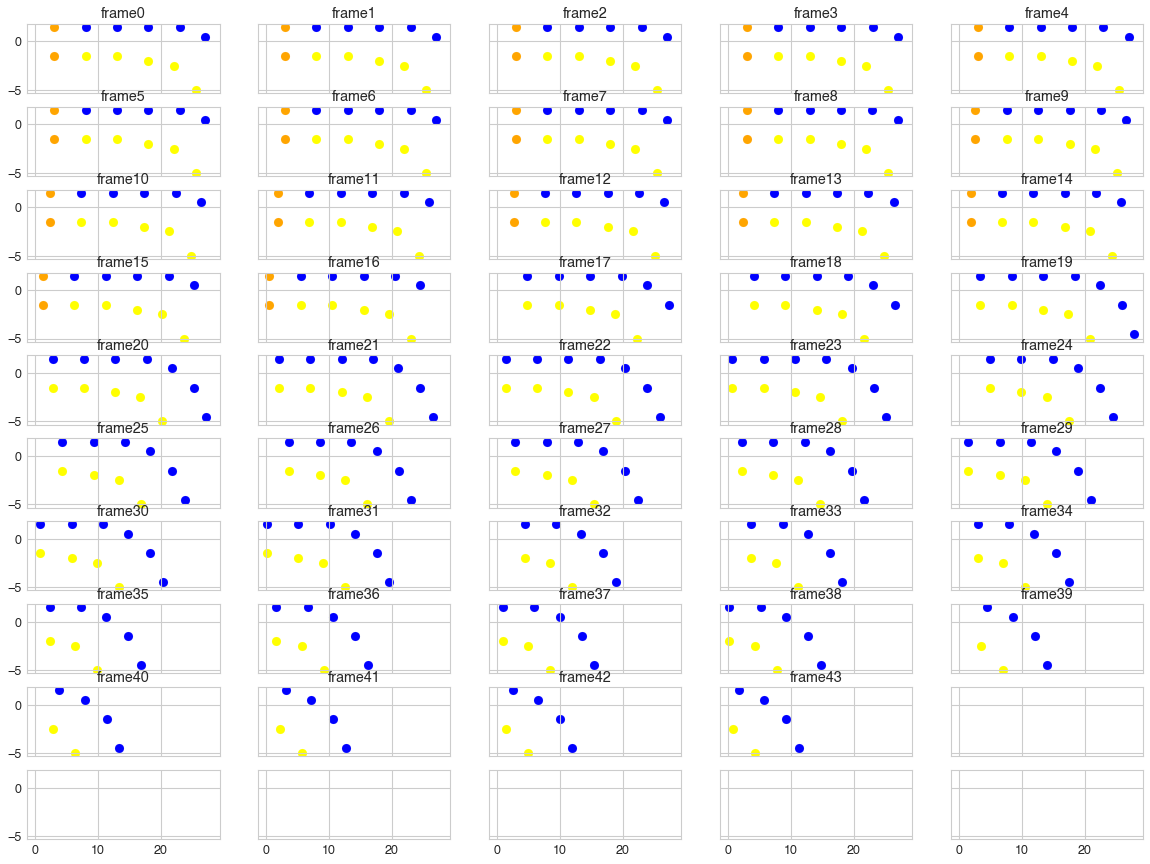

In [21]:
# create frames
frames2 = {}
for i, pos in enumerate(positions):
    frames2[f"frame{i}"] = draw_perception(pos, track_cones, 7)

# save them in a file
frames_file = 'perception.pkl'
with open(frames_file, 'wb') as fs:
        pickle.dump(frames2, fs, -1)
    
# plot them
fig, axs = plt.subplots(10, 5, sharex=True, sharey=True,figsize=(20,15))

for i, frame in enumerate(frames2):
    for cone in frames2[frame]:
        axs[math.floor(i/5), i%5].scatter(cone[0], cone[1], s=80, color=cone[3])
        axs[math.floor(i/5), i%5].set_title(f"{frame}")

plt.show()

In [18]:
with open(frames_file, 'rb') as lecturadeframes:
    lectura_frames = pickle.load(lecturadeframes)
lectura_frames["frame37"]

[[0.9310000000000009, 1.5, 0.9031255665908621, 'blue'],
 [5.931000000000001, 1.5, 0.9859277107566142, 'blue'],
 [9.931000000000001, 0.5, 0.8549060963589984, 'blue'],
 [13.431000000000001, -1.5, 0.7947544949510431, 'blue'],
 [15.431000000000001, -4.5, 0.9810176844403098, 'blue'],
 [0.9310000000000009, -2.0, 0.9342917232420972, 'yellow'],
 [4.931000000000001, -2.5, 0.9940588622134483, 'yellow'],
 [8.431000000000001, -5.0, 0.7158349891516883, 'yellow']]

In [ ]:
for i, frame in enumerate(frames2):
    blue_cns = []
    yellow_cns = []
    for cone in frames2[frame]:
        if(cone[3]=='blue'):
            blue_cns.append([cone[0]/1000,cone[1]/1000])
        elif(cone[3]=='yellow'):
            yellow_cns.append([cone[0]/1000,cone[1]/1000])
    print(frame, ": ")
    print("blue =", blue_cns)
    print("yellow =", yellow_cns)

In [7]:
trajectory_frame37 = [[0.0, 0.0, 0.0, 1.5], [0.05441256182915355, -0.13978295001604613, -1.1995786765846033, 1.5], [0.10882512365830688, -0.2795659000320927, -1.1995786765846033, 1.5], [0.16323768548746043, -0.4193488500481388, -1.1995786765846033, 1.5], [0.2176502473166141, -0.5591318000641854, -1.1995786765846033, 1.5], [0.2720628091457675, -0.698914750080232, -1.1995786765846033, 1.5], [0.3264753709749211, -0.8386977000962781, -1.1995786765846033, 1.5], [0.3808879328040745, -0.9784806501123247, -1.1995786765846033, 1.5], [0.43530049463322806, -1.1182636001283708, -1.1995786765846033, 1.5], [0.4897130564623815, -1.2580465501444171, -1.1995786765846033, 1.5], [0.544125618291535, -1.3978295001604635, -1.1995786765846033, 1.5], [0.5985381801206886, -1.53761245017651, -1.1995786765846033, 1.5], [0.652950741949842, -1.6773954001925564, -1.1995786765846033, 1.5], [0.7073633037789956, -1.8171783502086027, -1.1995786765846033, 1.5], [0.761775865608149, -1.956961300224649, -1.1995786765846033, 1.5], [0.8161884274373026, -2.096744250240696, -1.1995786765846033, 1.5], [0.8706009892664561, -2.236527200256742, -1.1995786765846033, 1.5], [0.9250135510956098,-2.3763101502727886, -1.1995786765846033, 1.5], [0.9794261129247632, -2.516093100288835, -1.1995786765846033, 1.5], [1.0338386747539168, -2.6558760503048813, -1.1995786765846033, 1.5], [1.0882512365830703, -2.795659000320928, -1.1995786765846033, 1.5], [1.1414585101847763, -2.935869306504028, -1.2605376750755428, 1.5], [1.1872542525275203, -3.07870750161751, -1.2605376750755428, 1.5], [1.2330499948702642, -3.221545696730991, -1.2605376750755428, 1.5], [1.2770984290912977, -3.3648922590239705, -1.3148007629440854, 1.5], [1.3150797272011985, -3.5100040124896594, -1.3148007629440854, 1.5], [1.353061025311099, -3.6551157659553484, -1.3148007629440854, 1.5], [1.3898812136436556, -3.800501092727065, -1.364005070281682, 1.5], [1.420679300906094, -3.947305308678022, -1.364005070281682, 1.5], [1.4514773881685326, -4.094109524628979, -1.364005070281682, 1.5], [1.4822754754309708, -4.240913740579936, -1.364005070281682, 1.5], [1.5068519636386377, -4.388878944642055, -1.4086191144856484, 1.5], [1.531072048244437, -4.5369106557775005, -1.4086191144856484, 1.5], [1.5552921328502363, -4.684942366912946, -1.4086191144856484, 1.5], [1.5760916059000536, -4.83346287215055, -1.4491018989969875, 1.5], [1.594300747477441, -4.982353527206584, -1.4491018989969875, 1.5], [1.6125098890548286, -5.131244182262616, -1.4491018989969875, 1.5], [1.6305803275190722, -5.280149216859806, -1.4858860923540333, 1.5], [1.643301563666708, -5.429608810566187, -1.4858860923540333, 1.5], [1.6560227998143442, -5.579068404272566, -1.4858860923540333, 1.5], [1.66874403596198, -5.728527997978945, -1.4858860923540333, 1.5], [1.679916150637081, -5.878093356996837, -1.5193693744468657, 1.5], [1.6876267936769684, -6.027895045852175, -1.5193693744468657, 1.5], [1.6953374367168559, -6.177696734707513, -1.5193693744468657, 1.5], [1.7030480797567435, -6.327498423562851, -1.5193693744468657, 1.5], [1.7088534584540895, -6.477369029301456, -1.5499111612528496, 1.5], [1.7119860055427818, -6.627336316230096, -1.5499111612528496, 1.5], [1.7151185526314738, -6.777303603158737, -1.5499111612528496, 1.5], [1.718251099720166, -6.927270890087377, -1.5499111612528496, 1.5], [1.7199501304618077, -7.077248103443822, -1.5778326524891038, 1.5], [1.7188946903168458, -7.227244390218196, -1.5778326524891038, 1.5], [1.7178392501718842, -7.377240676992571, -1.5778326524891038, 1.5], [1.7167838100269224, -7.527236963766946, -1.5778326524891038, 1.5], [1.7154058171135644, -7.677226853678094, -1.6034187819609333, 1.5], [1.710513316732943, -7.82714704391285, -1.6034187819609333, 1.5], [1.7056208163523217, -7.977067234147607, -1.6034187819609333, 1.5], [1.7007283159717002, -8.126987424382364, -1.6034187819609333, 1.5], [1.6958358155910787, -8.276907614617121, -1.6034187819609333, 1.5], [1.6886948674518736, -8.42672796752034, -1.6269211376844401, 1.5], [1.68028056494337, -8.57649177994943, -1.6269211376844401, 1.5], [1.6718662624348666, -8.72625559237852, -1.6269211376844401, 1.5], [1.663451959926363, -8.876019404807609, -1.6269211376844401,1.5], [1.6550287796435224, -9.025782622025767, -1.6485612663976303, 1.5], [1.643701299024836, -9.17535117376185, -1.6272484655134702, 1.5], [1.6352379751043873, -9.325112223932505, -1.6272484655134702, 1.5],[1.6267746511839385, -9.47487327410316, -1.6272484655134702, 1.5], [1.6183113272634897, -9.624634324273817, -1.6272484655134702, 1.5], [1.608861783630593, -9.77432972372796, -1.6472841403636724, 1.5], [1.598665217937009, -9.92397557387646, -1.6275293236522146, 1.5], [1.590159832741105, -10.073734241147069, -1.6275293236522146, 1.5], [1.5816544475452008, -10.223492908417679, -1.6275293236522146, 1.5], [1.5731490623492965, -10.37325157568829, -1.6275293236522146, 1.5], [1.5628144722839434, -10.522889230760486, -1.646182069866524, 1.5], [1.5535950755938455, -10.67260091636167, -1.6277729519190842, 1.5], [1.5450532052061636, -10.822357507035605, -1.6277729519190842, 1.5], [1.536511334818482, -10.972114097709538, -1.6277729519190842, 1.5], [1.5279694644308004, -11.12187068838347, -1.6277729519190842, 1.5], [1.517071041868955, -11.271472250646967, -1.6279862928008682, 1.5], [1.5084972224727973, -11.421227015582717, -1.6279862928008682, 1.5], [1.4999234030766393, -11.57098178051847, -1.6279862928008682, 1.5]]
# trajectory_frame37 = [[0.0, 0.0, 0.0, 1.5], [0.0905055261697656, -0.1196191863069378, -0.9230758111373308, 1.5], [0.18101105233953096, -0.23923837261387537, -0.9230758111373308, 1.5], [0.27151657850929656, -0.35885755892081317, -0.9230758111373308, 1.5], [0.36202210467906193, -0.47847674522775074, -0.9230758111373308, 1.5], [0.4525276308488275, -0.5980959315346885, -0.9230758111373308, 1.5], [0.5430331570185931, -0.7177151178416263, -0.9230758111373308, 1.5], [0.6335386831883586, -0.837334304148564, -0.9230758111373308, 1.5], [0.7240442093581241, -0.9569534904555017, -0.9230758111373308, 1.5], [0.8145497355278897, -1.0765726767624395, -0.9230758111373308, 1.5], [0.9050552616976553, -1.1961918630693773, -0.9230758111373308, 1.5], [0.9955607878674209, -1.315811049376315, -0.9230758111373308, 1.5], [1.0860663140371865, -1.435430235683253, -0.9230758111373308, 1.5], [1.2025002566039562, -1.5224091878780661, -0.4195210994579046, 1.5], [1.3328131523880253, -1.5965734026289027, -0.5256758439794503, 1.5], [1.4649639618395482, -1.6671368140391944, -0.41852423924124915, 1.5], [1.596931773953519, -1.7380538331420206, -0.5260648661214129, 1.5], [1.7273902265184802, -1.8119235915017025, -0.4175011338606498, 1.5], [1.8610550960468164, -1.8795055227735087, -0.5264642513894219, 1.5], [1.9907434629076717, -1.954877450577992, -0.5264642513894219, 1.5], [2.125183331444495, -2.0209273056642494, -0.5268744193343186, 1.5], [2.2548407722482473, -2.096352421137952, -0.5268744193343186, 1.5], [2.3893167057865767, -2.162317952055665, -0.5272958124566833, 1.5], [2.5189423514545797, -2.237797697584868, -0.5272958124566833, 1.5], [2.6517418547992433, -2.3070413190449903, -0.4142635800892815, 1.5], [2.7830484028949805, -2.379212041269015, -0.527728897797176, 1.5], [2.914072201436352, -2.4519340614406113, -0.413124429560457, 1.5], [3.0471591417042254, -2.520594143703653, -0.5281741686610772, 1.5], [3.1767184392742487, -2.596187717591664, -0.5281741686610772, 1.5], [3.3112747967934077, -2.661942621575416, -0.5286321464902092, 1.5], [3.4407994605966534, -2.73759552281956, -0.5286321464902092, 1.5], [3.5753956119562034, -2.8032560113209795, -0.5291033828972497, 1.5], [3.7048846109780373, -2.878969940900175, -0.5291033828972497, 1.5], [3.8383925840003834, -2.9467583584280517, -0.40950887188468094, 1.5], [3.9689741036352784, -3.0203094962861097, -0.5295884618790533, 1.5], [4.100614124441963, -3.0917676729727677, -0.40823280781165616, 1.5], [4.233068166357662, -3.16161262522082, -0.5300880022276232, 1.5], [4.362786605050936, -3.2368532228155757, -0.4069186675530484, 1.5], [4.497167042751419, -3.3028776690512567, -0.5306026601596965, 1.5], [4.626542380107962, -3.378785653373598, -0.5306026601596965, 1.5], [4.761270993612232, -3.444102866923194, -0.531133132188267, 1.5], [4.890606045705089, -3.520079470559696, -0.531133132188267, 1.5], [5.0248903421764, -3.58625587129913, -0.404169151823122, 1.5], [5.1546737700019465, -3.6613336897030186, -0.5316801582626177, 1.5], [5.286987394840209, -3.7313940662976557, -0.402730001030366, 1.5], [5.418745789488268, -3.8025464204289476, -0.5322445252064213, 1.5], [5.549028685265313, -3.8766178814639423, -0.4012452063017018, 1.5], [5.682822358695048, -3.943715650162683, -0.5328270704875095, 1.5], [5.812028525612008, -4.019911230287954, -0.5328270704875095, 1.5], [5.946903751903704, -4.084839234100328, -0.5334286863572545, 1.5], [6.076064054970676, -4.1611125329122185, -0.5334286863572545, 1.5], [6.210990265049477, -4.225914884176637, -0.5340503244024707, 1.5], [6.3401031287791705, -4.302268459204383, -0.5340503244024707, 1.5], [6.47315514504977, -4.37077562466836, -0.396494235083293, 1.5], [6.60414598429198, -4.443376693923195, -0.5346930005586145, 1.5], [6.73504441112701, -4.516153983940451, -0.39480337695193723, 1.5], [6.868192879067666, -4.584434761710325, -0.535357800639748, 1.5], [6.997205801981999, -4.660957083428243, -0.535357800639748, 1.5], [7.132244093099945, -4.725440013017728, -0.5360458864484181, 1.5], [7.26120433155345, -4.802051088574824, -0.5360458864484181, 1.5], [7.396299931215157, -4.866389608525709, -0.536758502537634, 1.5], [7.525205542643827, -4.943092563763437, -0.536758502537634, 1.5], [7.659069059077681, -5.0098652212153585, -0.3893692175528616, 1.5], [7.789209658371025, -5.0840786305402705, -0.5374969837076361, 1.5], [7.920780094519724, -5.155417576433822, -0.387426411788735, 1.5], [8.053216924109496, -5.225006196424839, -0.5382627633321474, 1.5], [8.18241319866233, -5.301086902122423, -0.3854118520600544, 1.5], [8.31722761013875, -5.36587193466247, -0.5390573826232244, 1.5], [8.445956550203194, -5.442871025500511, -0.5390573826232244, 1.5], [8.581242014661903, -5.506672261636615, -0.5398825009604051, 1.5], [8.709907377551128, -5.5837775428603065, -0.5398825009604051, 1.5], [8.84466461875299, -5.648603102709939, -0.38115103357019975, 1.5], [8.973859672290537, -5.724618883002425, -0.5407399074294384, 1.5], [9.106163846424229, -5.794353022236777, -0.3788957602570766, 1.5], [9.237813639303813, -5.8653911115981545, -0.5416315337390774, 1.5], [9.367571312300825, -5.940238361724232, -0.37655064129449956, 1.5], [9.50176950985074, -6.006089971541721, -0.5425594687116897, 1.5], [9.630228003617422, -6.083539409107113, -0.5425594687116897, 1.5], [9.765727545341147, -6.146710849201569, -0.5435259745758135, 1.5], [9.89411112378521, -6.224284406461096, -0.5435259745758135, 1.5]]
# trajectory_frame37 = [[0.0, 0.0, 0.0, 1.5], [0.0905055261697656, -0.1196191863069378, -0.9230758111373307, 1.5], [0.18101105233953096, -0.23923837261387537, -0.9230758111373307, 1.5], [0.27151657850929656, -0.35885755892081317, -0.9230758111373307, 1.5], [0.36202210467906193, -0.47847674522775074, -0.9230758111373307, 1.5], [0.4525276308488275, -0.5980959315346884, -0.9230758111373307, 1.5], [0.5430331570185931, -0.7177151178416262, -0.9230758111373307, 1.5], [0.6335386831883586, -0.8373343041485638, -0.9230758111373307, 1.5], [0.7240442093581241, -0.9569534904555016, -0.9230758111373307, 1.5], [0.8145497355278897, -1.0765726767624393, -0.9230758111373307, 1.5], [0.9050552616976553, -1.196191863069377, -0.9230758111373307, 1.5], [0.9955607878674209, -1.3158110493763149, -0.9230758111373307, 1.5], [1.0860663140371865, -1.4354302356832527, -0.9230758111373307, 1.5], [1.202500256603956, -1.5224091878780661, -0.4195210994579068, 1.5], [1.3328131523880253, -1.5965734026289025, -0.5256758439794503, 1.5], [1.464963961839548, -1.6671368140391947, -0.41852423924125504, 1.5], [1.5969317739535187, -1.738053833142021, -0.5260648661214128, 1.5], [1.7273902265184802, -1.811923591501703, -0.4175011338606456, 1.5], [1.8610550960468164, -1.8795055227735087, -0.5264642513894219, 1.5], [1.9907434629076715, -1.954877450577992, -0.5264642513894219, 1.5], [2.125183331444495, -2.0209273056642494, -0.5268744193343186, 1.5], [2.2548407722482473, -2.096352421137952, -0.5268744193343186, 1.5], [2.3893167057865763, -2.1623179520556652, -0.5272958124566819, 1.5], [2.5189423514545792, -2.2377976975848686, -0.5272958124566819, 1.5], [2.6517418547992433, -2.3070413190449903, -0.41426358008927633, 1.5], [2.783048402894981, -2.379212041269015, -0.5277288977971779, 1.5], [2.914072201436352, -2.4519340614406113, -0.413124429560457, 1.5], [3.0471591417042254, -2.520594143703653, -0.5281741686610772, 1.5], [3.1767184392742482, -2.596187717591664, -0.5281741686610772, 1.5], [3.3112747967934077, -2.6619426215754154, -0.5286321464902092, 1.5], [3.440799460596653, -2.73759552281956, -0.5286321464902092, 1.5], [3.5753956119562034, -2.8032560113209795, -0.5291033828972497, 1.5], [3.7048846109780373, -2.878969940900175, -0.5291033828972497, 1.5], [3.8383925840003834, -2.946758358428052, -0.40950887188468393, 1.5], [3.968974103635278, -3.0203094962861097, -0.5295884618790528, 1.5], [4.100614124441963, -3.0917676729727677, -0.40823280781165616, 1.5], [4.233068166357662, -3.16161262522082, -0.5300880022276232, 1.5], [4.362786605050936, -3.2368532228155757, -0.40691866755304895, 1.5], [4.497167042751419, -3.3028776690512567, -0.5306026601596984, 1.5], [4.626542380107962, -3.378785653373598, -0.5306026601596984, 1.5], [4.761270993612232, -3.444102866923194, -0.5311331321882702, 1.5], [4.890606045705088, -3.5200794705596965, -0.5311331321882702, 1.5], [5.0248903421764, -3.58625587129913, -0.40416915182311347, 1.5], [5.1546737700019465, -3.661333689703018, -0.5316801582626177, 1.5], [5.286987394840209, -3.7313940662976557, -0.402730001030366, 1.5], [5.418745789488268, -3.802546420428947, -0.5322445252064213, 1.5], [5.549028685265312, -3.8766178814639423, -0.40124520630170246, 1.5], [5.682822358695048, -3.943715650162683, -0.5328270704875099, 1.5], [5.812028525612008, -4.019911230287953, -0.5328270704875099, 1.5], [5.946903751903704, -4.084839234100327, -0.5334286863572558, 1.5], [6.076064054970675, -4.1611125329122185, -0.5334286863572558, 1.5], [6.210990265049476, -4.225914884176637, -0.5340503244024707, 1.5], [6.3401031287791705, -4.302268459204383, -0.5340503244024707, 1.5], [6.47315514504977, -4.37077562466836, -0.396494235083293, 1.5], [6.60414598429198, -4.443376693923195, -0.5346930005586145, 1.5], [6.73504441112701, -4.516153983940451, -0.39480337695193723, 1.5], [6.868192879067665, -4.584434761710325, -0.535357800639748, 1.5], [6.997205801981998, -4.660957083428242, -0.535357800639748, 1.5], [7.132244093099945, -4.725440013017728, -0.5360458864484181, 1.5], [7.261204331553449, -4.802051088574824, -0.5360458864484181, 1.5], [7.396299931215157, -4.866389608525709, -0.5367585025376352, 1.5], [7.5252055426438265, -4.943092563763436, -0.5367585025376352, 1.5], [7.659069059077681, -5.0098652212153585, -0.3893692175528616, 1.5], [7.789209658371025, -5.0840786305402705, -0.537496983707638, 1.5], [7.920780094519724, -5.155417576433822, -0.38742641178873144, 1.5], [8.053216924109496, -5.225006196424839, -0.5382627633321474, 1.5], [8.18241319866233, -5.301086902122422, -0.3854118520600544, 1.5], [8.31722761013875, -5.36587193466247, -0.5390573826232277, 1.5], [8.445956550203194, -5.442871025500511, -0.5390573826232277, 1.5], [8.581242014661903, -5.506672261636614, -0.5398825009604051, 1.5], [8.709907377551126, -5.583777542860306, -0.5398825009604051, 1.5], [8.844664618752988, -5.648603102709938, -0.3811510335701911, 1.5], [8.973859672290535, -5.7246188830024245, -0.5407399074294416, 1.5], [9.106163846424227, -5.794353022236777, -0.3788957602570766, 1.5], [9.237813639303813, -5.8653911115981545, -0.5416315337390774, 1.5], [9.367571312300825, -5.940238361724231, -0.37655064129449956, 1.5], [9.50176950985074, -6.00608997154172, -0.5425594687116897, 1.5], [9.630228003617422, -6.083539409107113, -0.5425594687116897, 1.5], [9.765727545341147, -6.146710849201569, -0.5435259745758135, 1.5], [9.89411112378521, -6.224284406461096, -0.5435259745758135, 1.5]]
traj_f37 = trajectory_frame37[1::6]
#print(traj_f37)

plt.figure(figsize=(3, 6))

rot_cent = [0,0]
rot_angl = trajectory_frame37[1][3]

for cone in frames2["frame37"]:
    rox, roy = rotate(rot_cent, [cone[0], cone[1]], rot_angl)
    #plt.scatter(-cone[1], cone[0], s=80, color=cone[3])
    plt.scatter(rox, roy, s=80, color=cone[3])

for i, step in enumerate(traj_f37):
    rox, roy = rotate(rot_cent, [-step[1],step[0]], rot_angl-0.4)
    #rot_cent = [rox/1000, roy/1000]
    #plt.scatter(-step[1]*1000,step[0]*1000, s=80, marker= "^", markersize=10, color="red")
    #plt.scatter(rox, roy, s=80, marker= "^", color="red")
    plt.plot(rox, roy, marker=(3, 0, (i/len(traj_f37))*(-step[3]+0.4)*180/math.pi), markersize=10, linestyle='None', color="red")

    #plt.plot(rox, roy, marker=(3, 0, (i/len(traj_f37))*(-step[3]+0.4)*180/math.pi), markersize=10, linestyle='None', color="red")

plt.title("frame 37")
    
plt.show()

KeyError: 'frame37'

<Figure size 216x432 with 0 Axes>

NameError: name 'last_positions' is not defined

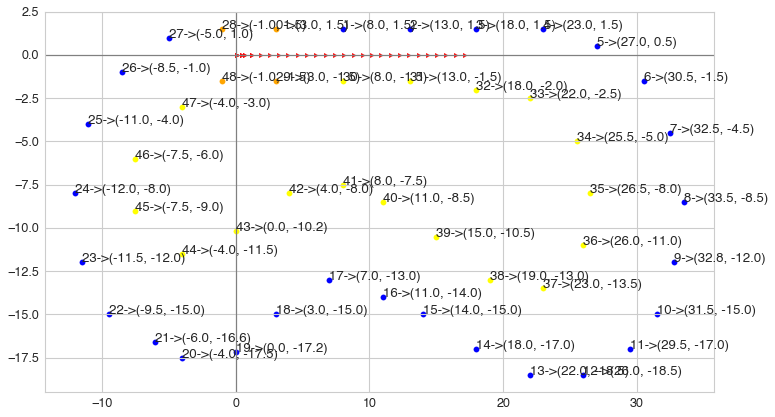

In [26]:
# plot        
plt.figure(figsize=(12, 7))

for i, cone in enumerate(track_cones):
    plt.scatter(cone.values[0], cone.values[1], color=cone.color)
    plt.annotate(f"{i}->{round(cone.values[0],1), round(cone.values[1],1)}", (cone.values[0], cone.values[1]))
    # plt.annotate(f"{i}", (cone.pose[0], cone.pose[1]))
    
plt.axhline(y=0, color='grey')
plt.axvline(x=0, color='grey')

poses = positions[:-6]
frames = {}

last_x, last_y, last_angl = poses[-1]
rot_cent = [last_x, last_y]
for i, pos in enumerate(poses):
    frames[f"frame{i}"] = draw_perception(pos, track_cones)
    plt.scatter(pos[0], pos[1], marker=(3, 0, -90), color="red")

last_positons = []
    
for i, step in enumerate(traj_f37[1:-1]):

    rox, roy = rotate(rot_cent, [last_x+step[0], last_y+step[1]], rot_angl-math.pi/8)
    # rot_cent = [rox, roy]
    last_positions.append([rox, roy])
    plt.scatter(rox, last_y+roy, marker=(3, 0, ((i/len(traj_f37))*(-step[3]+0.4)*180/math.pi)-90), color="red")
    

In [25]:
!ls

input_generation.ipynb perception.pkl


In [ ]:
with open('../motion.csv', mode='w') as motions:
    for i, pos in enumerate(poses):
        employee_writer = csv.writer(motions, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        employee_writer.writerow([pos[0], pos[1]])


#### Introducing noise

### 0.2.- Motion estimation

We will receive x, y, heading, and velocity.

### 1.- Filtering

#### 1.1.- Iterative closest point

#### 1.2.- EKF SLAM 

#### 1.3. FastSLAM 1.0

#### 1.4. FastSLAM 2.0

#### 1.5. GraphSLAM

In [ ]:
bluees = [[-1.5, 3.0],[-1.5, 8.0],[-1.5, 13.0],[-1.5, 18.0],[-1.5, 23.0],[-0.5, 27.0],[1.5, 30.5],[4.5, 32.5],[8.5, 33.5],[12.0, 32.8],[15.0, 31.5],[17.0, 29.5],[18.5, 26.0],[18.5, 22.0],[17.0, 18.0],[15.0, 14.0],[14.0, 11.0],[13.0, 7.0],[15.0, 3.0],[17.2, 0.0],[17.5, -4.0],[16.6, -6.0],[15.0, -9.5],[12.0, -11.5],[8.0, -12.0],[4.0, -11.0],[1.0, -8.5],[-1.0, -5.0],[-1.5, -1.0]] # Ejemplo, hay que cambiarlo por coordenadas reales
yellowes = [[1.5, 3.0], [1.5, 8.0], [1.5, 13.0], [2.0, 18.0], [2.5, 22.0], [5.0, 25.5], [8.0, 26.5], [11.0, 26.0], [13.5, 23.0], [13.0, 19.0], [10.5, 15.0], [8.5, 11.0], [7.5, 8.0], [8.0, 4.0], [10.2, 0.0], [11.5, -4.0], [9.0, -7.5], [6.0, -7.5], [3.0, -4.0], [1.5, -1.0]] # Ejemplo, hay que cambiarlo por coordenadas reales

blue = {}
yellow = {}

i = 0
for blu in bluees:
    print(blu)
    
#    
#j = 0
#for yello in yellowes:
#    yellow[f"cone{i}"] = yello
#    if(i%5==0):
#        i+=1
# blue, yellow

blue

### Fast SLAM

According to research, Fast SLAM is better in terms of efficiency. An even better implementation comes with Fast SLAM 2.0. So in this section, a version of this algorithm will try to be implemented.

We should be recieving data from 2 different modules: Perception (Camera and Lidar) and Motion Estimation (Odometry). And the results will be sent to Path Planning.

Depending on how we receive the parameters, the implementation will vary, but in order to start we will assume the structure of these.

In [60]:
positions = []
for i in range(75):
    positions.append([10*0.033*i, 0, 10, 0])
    
positions_file = 'motions.pkl'
with open(positions_file, 'wb') as fs:
        pickle.dump(positions, fs, -1)
positions

[[0.0, 0, 10, 0],
 [0.33, 0, 10, 0],
 [0.66, 0, 10, 0],
 [0.99, 0, 10, 0],
 [1.32, 0, 10, 0],
 [1.6500000000000001, 0, 10, 0],
 [1.98, 0, 10, 0],
 [2.31, 0, 10, 0],
 [2.64, 0, 10, 0],
 [2.97, 0, 10, 0],
 [3.3000000000000003, 0, 10, 0],
 [3.6300000000000003, 0, 10, 0],
 [3.96, 0, 10, 0],
 [4.29, 0, 10, 0],
 [4.62, 0, 10, 0],
 [4.95, 0, 10, 0],
 [5.28, 0, 10, 0],
 [5.61, 0, 10, 0],
 [5.94, 0, 10, 0],
 [6.2700000000000005, 0, 10, 0],
 [6.6000000000000005, 0, 10, 0],
 [6.930000000000001, 0, 10, 0],
 [7.260000000000001, 0, 10, 0],
 [7.590000000000001, 0, 10, 0],
 [7.92, 0, 10, 0],
 [8.25, 0, 10, 0],
 [8.58, 0, 10, 0],
 [8.91, 0, 10, 0],
 [9.24, 0, 10, 0],
 [9.57, 0, 10, 0],
 [9.9, 0, 10, 0],
 [10.23, 0, 10, 0],
 [10.56, 0, 10, 0],
 [10.89, 0, 10, 0],
 [11.22, 0, 10, 0],
 [11.55, 0, 10, 0],
 [11.88, 0, 10, 0],
 [12.21, 0, 10, 0],
 [12.540000000000001, 0, 10, 0],
 [12.870000000000001, 0, 10, 0],
 [13.200000000000001, 0, 10, 0],
 [13.530000000000001, 0, 10, 0],
 [13.860000000000001, 0, 10, 0],

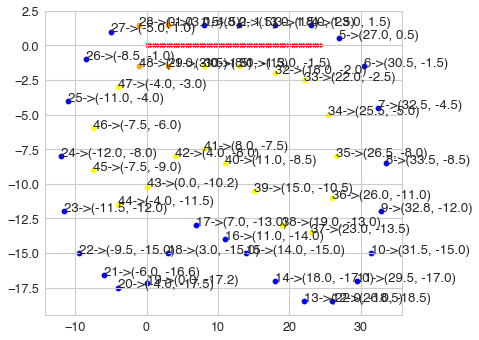

In [47]:
frames = {}
for i, pos in enumerate(positions):
    frames[f"frame{i}"] = draw_perception(pos, track_cones)
    plt.scatter(pos[0], pos[1], marker=(3, 0, -90), color="red")
    
for i, cone in enumerate(track_cones):
    plt.scatter(cone.values[0], cone.values[1], color=cone.color)
    plt.annotate(f"{i}->{round(cone.values[0],1), round(cone.values[1],1)}", (cone.values[0], cone.values[1]))
    # plt.annotate(f"{i}", (cone.pose[0], cone.pose[1]))
 

In [59]:
def draw_perception_2(pos, track_cones, srange=10):
    sens_range = srange
    car_perc = []
    for cone in track_cones:
        #print(pos[2] >= 0  , pos[0] <= (math.pi/2) , float(cone.values[0])>pos[0]  , float(cone.values[0])<pos[0]+sens_range  , float(abs(cone.values[1]))<pos[1]+sens_range)
        if(  (pos[2] >= 0) 
           & (cone.values[0]>pos[0])
           & (cone.values[0]<pos[0]+sens_range*4)
           & (abs(cone.values[1])<pos[1]+sens_range)):
            car_perc.append([cone.values[0]-pos[0], cone.values[1]-pos[1], cone.values[2], cone.values[3]])
    return car_perc

frames3 = {}
for i, pos in enumerate(positions):
    frames3[f"frame{i}"] = draw_perception_2(pos, track_cones, 7)
    
    
# save them in a file
frames_file = 'perception.pkl'
with open(frames_file, 'wb') as fs:
        pickle.dump(frames3, fs, -1)
       
frames3

{'frame0': [[3.0, 1.5, 1, 'orange'],
  [8.0, 1.5, 0.9658022578969557, 'blue'],
  [13.0, 1.5, 0.9270060661725678, 'blue'],
  [18.0, 1.5, 0.9031255665908621, 'blue'],
  [23.0, 1.5, 0.9859277107566142, 'blue'],
  [27.0, 0.5, 0.8549060963589984, 'blue'],
  [3.0, -1.5, 1, 'orange'],
  [8.0, -1.5, 0.9122858022192998, 'yellow'],
  [13.0, -1.5, 0.8379582471824497, 'yellow'],
  [18.0, -2.0, 0.9342917232420972, 'yellow'],
  [22.0, -2.5, 0.9940588622134483, 'yellow'],
  [25.5, -5.0, 0.7158349891516883, 'yellow']],
 'frame1': [[2.67, 1.5, 1, 'orange'],
  [7.67, 1.5, 0.9658022578969557, 'blue'],
  [12.67, 1.5, 0.9270060661725678, 'blue'],
  [17.67, 1.5, 0.9031255665908621, 'blue'],
  [22.67, 1.5, 0.9859277107566142, 'blue'],
  [26.67, 0.5, 0.8549060963589984, 'blue'],
  [2.67, -1.5, 1, 'orange'],
  [7.67, -1.5, 0.9122858022192998, 'yellow'],
  [12.67, -1.5, 0.8379582471824497, 'yellow'],
  [17.67, -2.0, 0.9342917232420972, 'yellow'],
  [21.67, -2.5, 0.9940588622134483, 'yellow'],
  [25.17, -5.0, 0.